# Image Segmentation Pipeline

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from sklearn.cluster import KMeans
from toolz import pipe

## Function Definitions

This is just a utility function to print the resulting images of every step of the process (e.g. K Means, Components, etc)

In [55]:
def displayImage(image, title = "Image", cmap = None):
    plt.figure(figsize = (8, 8))
    plt.imshow(image, cmap = cmap) if cmap else plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

Function to read image from a file in RGB format

In [56]:
def readImage(file):
    image = cv2.imread(file)
    displayImage(image)

    return image

Function to perform the K Means segmentation of the image

**NOTE.** It is not a manual implementation, uses the _scikit-learn_ library

In [57]:
def kMeansSegmentation(prevFuncOutput, k = 3):

    image = prevFuncOutput

    # Reshape the image into a 2D array of pixels
    pixels = image.reshape((-1, 3))
    
    # Apply KMeans using scikit-learn
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pixels)
    centroids = kmeans.cluster_centers_
    
    # Assign each pixel to the nearest centroid
    segmentedImage = centroids[labels].reshape(image.shape).astype(np.uint8)
    
    displayImage(segmentedImage, "K-means Segmentation")
    
    # Reshape labels to match the original image dimensions
    segmentedImage = labels.reshape(image.shape[:2])
    return image, segmentedImage

Function to extract connected components

In [58]:
def extractConnectedComponents(prevFuncOutput, minArea = 500):

    originalImage, segmentedImage = prevFuncOutput

    height, width = segmentedImage.shape
    labeledImage = np.zeros_like(segmentedImage, dtype = np.int32)
    currentLabel = 1
    
    # Label connected components using a stack
    def floodFill(x, y, label):
        stack = [(x, y)]
        componentPixels = []
        
        while stack:
            cx, cy = stack.pop()
            if labeledImage[cx, cy] == 0 and segmentedImage[cx, cy] == segmentedImage[x, y]:
                labeledImage[cx, cy] = label
                componentPixels.append((cx, cy))
                
                # Check neighbors
                for nx, ny in [(cx + 1, cy), (cx - 1, cy), (cx, cy + 1), (cx, cy - 1)]:
                    if (0 <= nx and nx < height) and (0 <= ny and ny < width) and labeledImage[nx, ny] == 0:
                        stack.append((nx, ny))
        
        return componentPixels
    
    for i in range(height):
        for j in range(width):
            if labeledImage[i, j] == 0:
                componentPixels = floodFill(i, j, currentLabel)
                
                # Check the area of the component, if it's too small, don't take it into account
                # This is necessary for the program to avoid considering really small components (which are a lot)
                if len(componentPixels) >= minArea:
                    currentLabel += 1
                else:
                    for x, y in componentPixels:
                        labeledImage[x, y] = 0
    
    displayImage(labeledImage, "Connected Components After Filtering", cmap="jet")
    return labeledImage, originalImage, currentLabel - 1

In [59]:
def computeFeatures(prevFuncOutput):

    labeledImage, originalImage, numLabels = prevFuncOutput
    
    for component in range(1, numLabels + 1):
        # Extract mask for the current component
        mask = (labeledImage == component)
        componentPixels = originalImage[mask]

        # Compute area
        area = np.sum(mask)
        
        # Compute perimeter
        # This is done by checking border pixels
        perimeter = 0
        height, width = mask.shape
        for x in range(height):
            for y in range(width):
                if mask[x, y]:
                    # Check if this pixel has any background neighbors
                    neighbors = [
                        (x-1, y),
                        (x+1, y),
                        (x, y-1),
                        (x, y+1),
                        (x-1, y-1),
                        (x+1, y-1),
                        (x+1, y+1),
                        (x-1, y+1),
                    ]
                    if any((0 <= nx and nx < height) and (0 <= ny and ny < width) and not mask[nx, ny] for nx, ny in neighbors):
                        perimeter += 1

        # Compute Hu moments (descriptors of the image)
        moments = cv2.moments(mask.astype(np.uint8))
        huMoments = cv2.HuMoments(moments).flatten()
        
        # Calculate mean and variance for each color channel
        meanColor = np.mean(componentPixels, axis=0)
        varColor = np.var(componentPixels, axis=0)
        
        # Display the results for each component
        print("Component:", component)
        print("Area:", area)
        print("Perimeter:", perimeter)
        print("Hu Moments:")
        for i, moment in enumerate(huMoments):
            print(f"\t- Moment {i+1}: {moment}")
        print("Mean per Color:", meanColor)
        print(f"\t- Red: {meanColor[0]}")
        print(f"\t- Green: {meanColor[1]}")
        print(f"\t- Blue: {meanColor[2]}")
        print("Variance per Color:", varColor)
        print(f"\t- Red: {varColor[0]}")
        print(f"\t- Green: {varColor[1]}")
        print(f"\t- Blue: {varColor[2]}")
        displayImage(mask.astype(np.uint8) * 255, f"Component {component}")

## Pipeline

Definition of the pipeline

In [60]:
segmentationPipe = lambda file: pipe(
    file,
    readImage,
    kMeansSegmentation,
    extractConnectedComponents,
    computeFeatures
)

### Testing of the pipeline with simple image

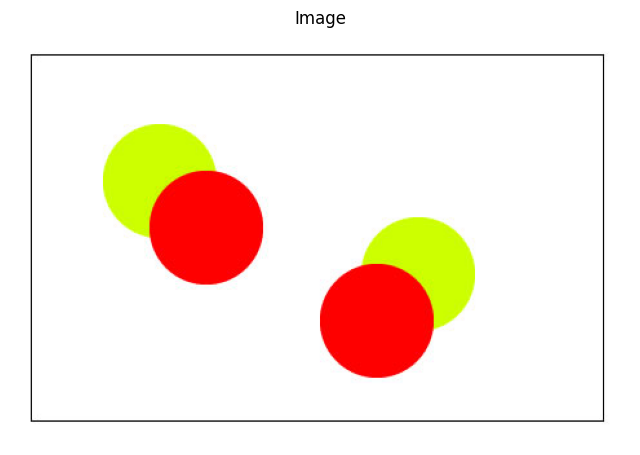

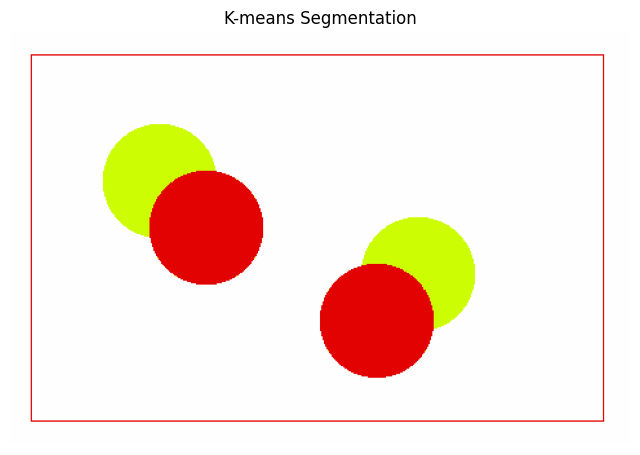

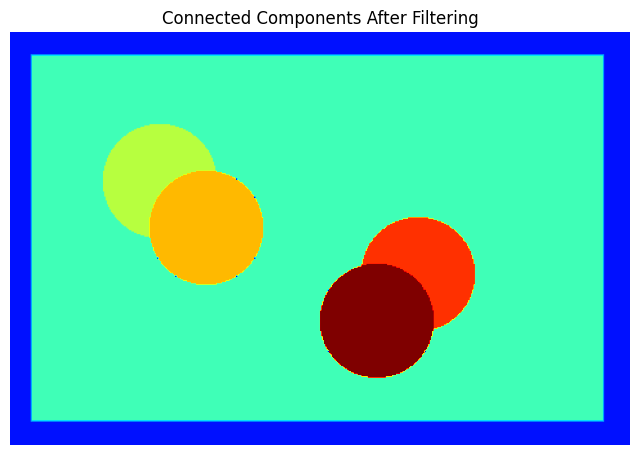

Component: 1
Area: 27504
Perimeter: 1460
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 1.7687155439238433
	- Moment 1: 0.29606785574954286
	- Moment 2: 0.0010160231101615516
	- Moment 3: 0.012824069719031252
	- Moment 4: 4.629036432057636e-05
	- Moment 5: 0.006977847915219803
	- Moment 6: 1.16384248238702e-18
Mean per Color: [254.87449098 254.87449098 254.87449098]
	- Red: 254.87449098312973
	- Green: 254.87449098312973
	- Blue: 254.87449098312973
Variance per Color: [0.41109449 0.41109449 0.41109449]
	- Red: 0.4110944907564555
	- Green: 0.4110944907564555
	- Blue: 0.4110944907564555


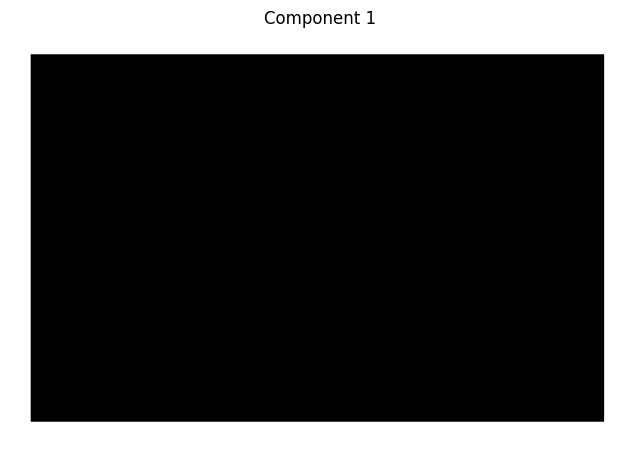

Component: 2
Area: 1452
Perimeter: 1452
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 30.250114784205692
	- Moment 1: 96.78871947460854
	- Moment 2: 0.0
	- Moment 3: 0.0
	- Moment 4: 0.0
	- Moment 5: 0.0
	- Moment 6: 0.0
Mean per Color: [3.90633609 3.90633609 3.90633609]
	- Red: 3.90633608815427
	- Green: 3.90633608815427
	- Blue: 3.90633608815427
Variance per Color: [4.1399874 4.1399874 4.1399874]
	- Red: 4.139987402196372
	- Green: 4.139987402196372
	- Blue: 4.139987402196372


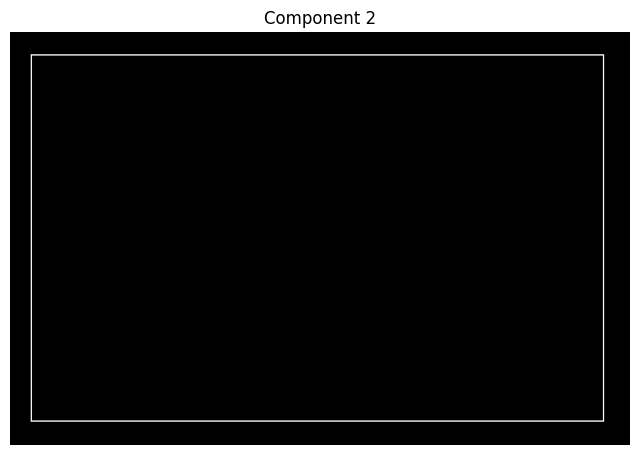

Component: 3
Area: 104069
Perimeter: 2436
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.2433155132092546
	- Moment 1: 0.010045535617394517
	- Moment 2: 2.1956159413327416e-05
	- Moment 3: 2.9830376979103953e-05
	- Moment 4: 7.471760985551894e-10
	- Moment 5: 1.798966739532681e-06
	- Moment 6: 1.5666971785622866e-10
Mean per Color: [254.64397659 254.81345069 254.85747917]
	- Red: 254.64397659245307
	- Green: 254.81345069136822
	- Blue: 254.8574791724721
Variance per Color: [16.21735557  6.63761862  1.29341236]
	- Red: 16.21735556913118
	- Green: 6.637618615739643
	- Blue: 1.2934123618542996


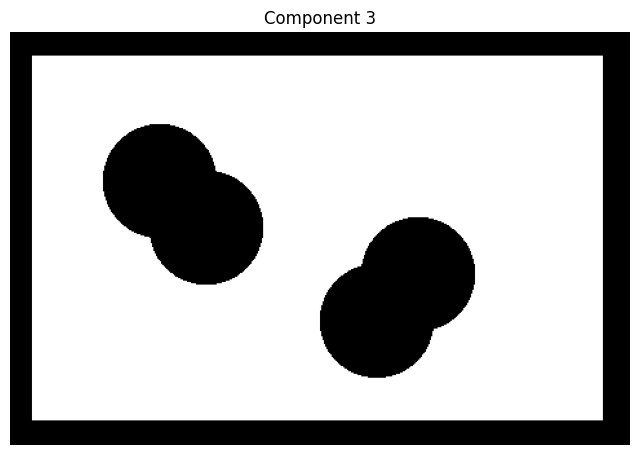

Component: 4
Area: 4242
Perimeter: 344
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.19657846421308667
	- Moment 1: 0.006230219558675814
	- Moment 2: 0.0015136260611304997
	- Moment 3: 0.00014173407357467974
	- Moment 4: -6.564787948504491e-08
	- Moment 5: -1.1187317025905981e-05
	- Moment 6: 0.0
Mean per Color: [  3.57920792 254.09193777 205.51461575]
	- Red: 3.5792079207920793
	- Green: 254.0919377652051
	- Blue: 205.514615747289
Variance per Color: [190.16357523  33.88735131  18.12814564]
	- Red: 190.16357523306095
	- Green: 33.88735131342925
	- Blue: 18.128145644428812


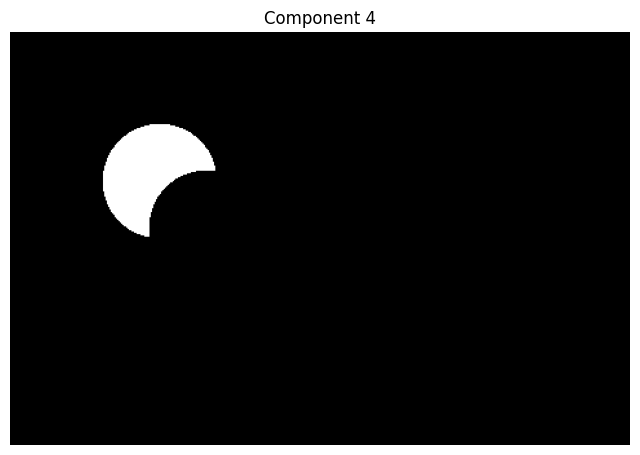

Component: 5
Area: 6142
Perimeter: 348
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.15915087709677453
	- Moment 1: 8.725300249498296e-09
	- Moment 2: 2.084713721447313e-09
	- Moment 3: 7.243136532865963e-15
	- Moment 4: 2.814577554890952e-26
	- Moment 5: 6.765764266672658e-19
	- Moment 6: 0.0
Mean per Color: [  2.07147509   2.36763269 253.00179095]
	- Red: 2.071475089547379
	- Green: 2.3676326929338978
	- Blue: 253.00179094757408
Variance per Color: [126.85991899 151.76422751  12.25154352]
	- Red: 126.85991898984527
	- Green: 151.76422751209788
	- Blue: 12.251543519957702


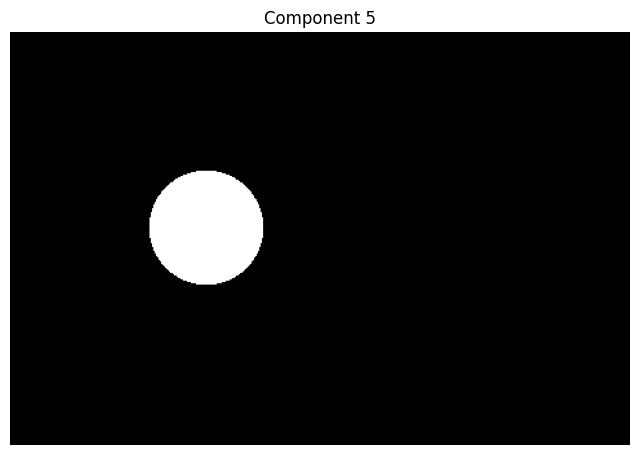

Component: 6
Area: 4045
Perimeter: 345
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.2040258376706455
	- Moment 1: 0.007776828547460952
	- Moment 2: 0.0019352641861429853
	- Moment 3: 0.00019706217964117798
	- Moment 4: -1.2169263877235933e-07
	- Moment 5: -1.7378033434109402e-05
	- Moment 6: -8.560246303856881e-10
Mean per Color: [  3.58640297 254.03312732 205.59826947]
	- Red: 3.5864029666254633
	- Green: 254.03312731767613
	- Blue: 205.5982694684796
Variance per Color: [195.44698447  42.4636739   16.2309488 ]
	- Red: 195.4469844655733
	- Green: 42.46367390344306
	- Blue: 16.23094879759626


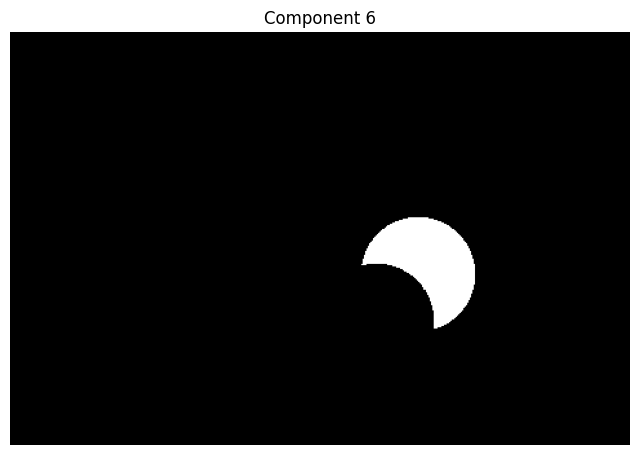

Component: 7
Area: 6137
Perimeter: 348
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.15915192172606438
	- Moment 1: 1.833214089137031e-08
	- Moment 2: 3.3655116913252047e-09
	- Moment 3: 1.9707936774390674e-13
	- Moment 4: -3.623737110205693e-24
	- Moment 5: 8.394656154049767e-18
	- Moment 6: 3.553903948694025e-24
Mean per Color: [  1.98598664   2.27146814 253.02020531]
	- Red: 1.985986638422682
	- Green: 2.2714681440443214
	- Blue: 253.02020531204172
Variance per Color: [122.49678912 148.30205867  14.35676952]
	- Red: 122.49678912350116
	- Green: 148.30205867232308
	- Blue: 14.356769519523297


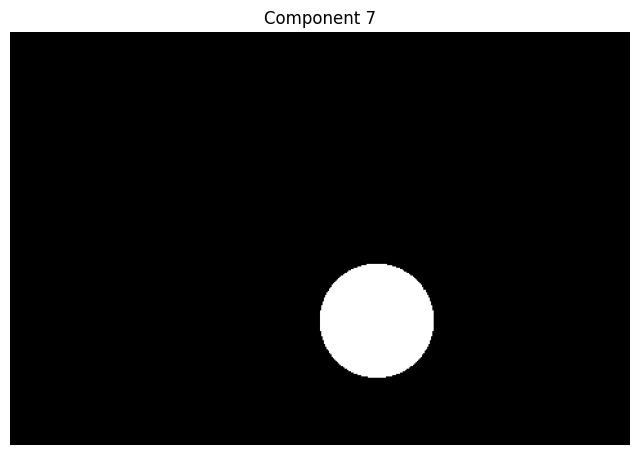

In [61]:
segmentationPipe("testImg5.jpg")

### Testing of the pipeline with complex image

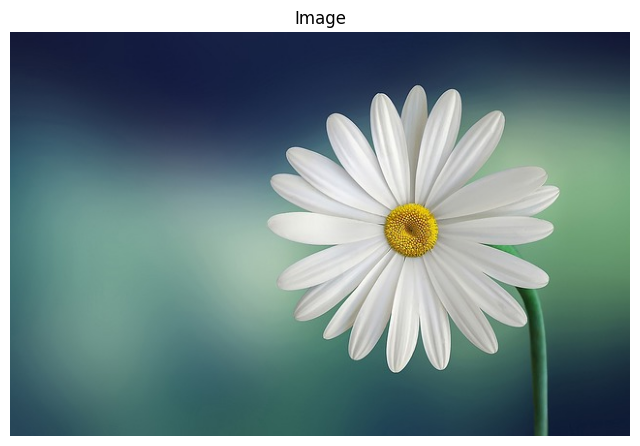

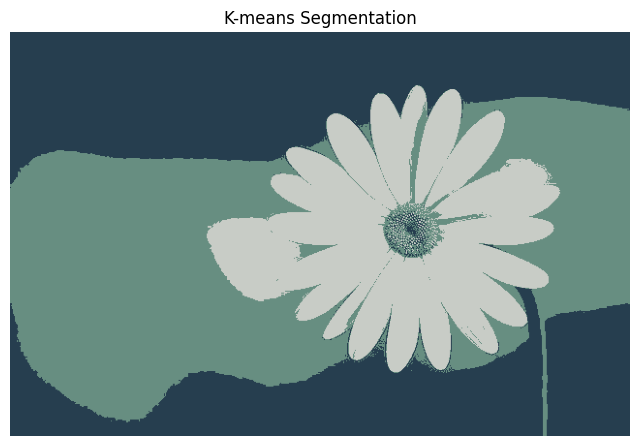

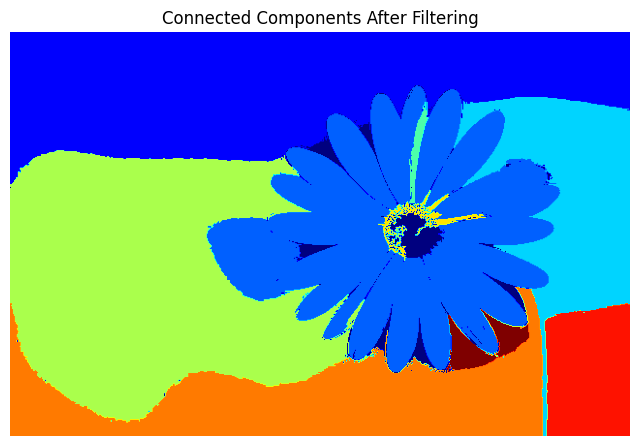

Component: 1
Area: 64921
Perimeter: 1062
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.510851418138332
	- Moment 1: 0.2271801145423544
	- Moment 2: 0.021351455622506395
	- Moment 3: 0.016565351862979128
	- Moment 4: 0.00031153985856705534
	- Moment 5: 0.00789317106218676
	- Moment 6: -7.085870627173888e-07
Mean per Color: [77.42182037 49.57950432 34.43645354]
	- Red: 77.42182036629134
	- Green: 49.57950432063585
	- Blue: 34.43645353583586
Variance per Color: [217.0437524  397.20534016 204.23434773]
	- Red: 217.04375239565204
	- Green: 397.2053401588021
	- Blue: 204.23434773129142


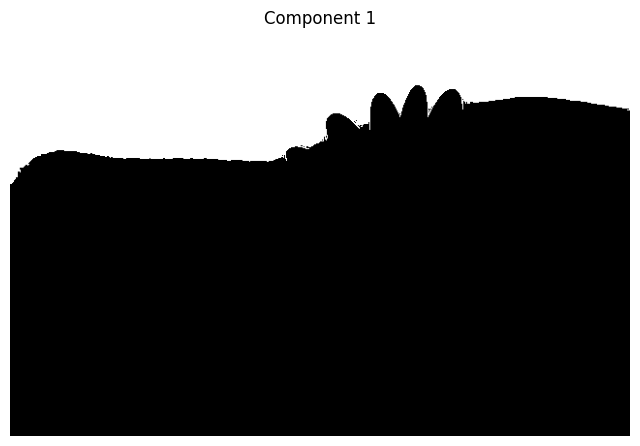

Component: 2
Area: 57373
Perimeter: 5059
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.20215466972430252
	- Moment 1: 0.002293836214287736
	- Moment 2: 0.0005123385703267801
	- Moment 3: 1.4345764087782357e-05
	- Moment 4: 1.0587531452095002e-09
	- Moment 5: 6.369083631637878e-07
	- Moment 6: -6.25824052192238e-10
Mean per Color: [199.63796559 204.30808917 200.01563453]
	- Red: 199.6379655935719
	- Green: 204.30808917086435
	- Blue: 200.01563453192267
Variance per Color: [467.42079346 354.55235417 533.36438701]
	- Red: 467.4207934628551
	- Green: 354.5523541703473
	- Blue: 533.3643870082847


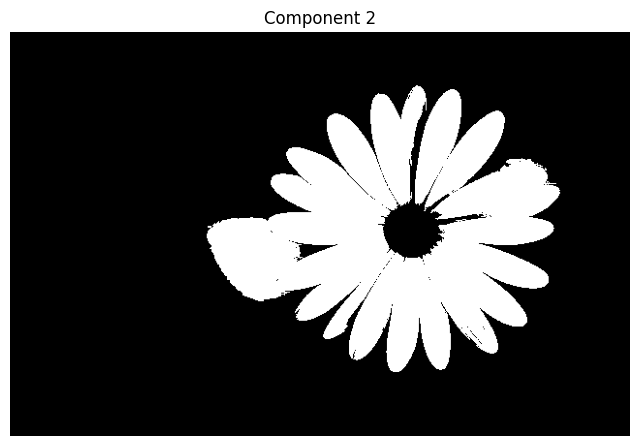

Component: 3
Area: 24362
Perimeter: 1396
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.2699444541371415
	- Moment 1: 0.021875892102851326
	- Moment 2: 0.006128320609460907
	- Moment 3: 0.0013100390755997676
	- Moment 4: -1.7189370288807595e-07
	- Moment 5: -1.5945582145694576e-05
	- Moment 6: -3.707925006121065e-06
Mean per Color: [121.62445612 150.8610541  109.67330268]
	- Red: 121.62445612018718
	- Green: 150.86105410064854
	- Blue: 109.67330268450866
Variance per Color: [232.4121644 458.8158061 422.8169615]
	- Red: 232.412164397131
	- Green: 458.8158060968087
	- Blue: 422.81696150011726


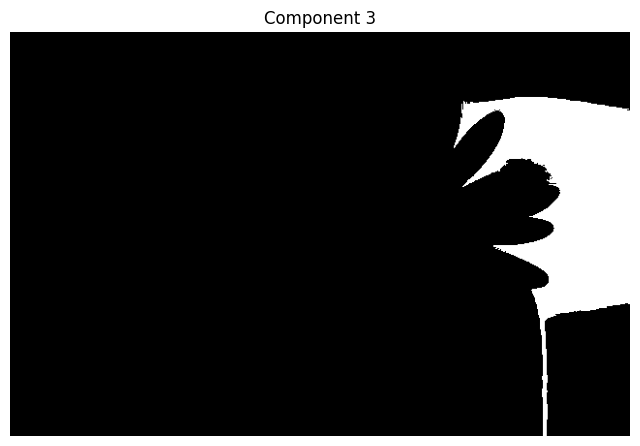

Component: 4
Area: 671
Perimeter: 288
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 1.129180583138653
	- Moment 1: 1.2334889421146444
	- Moment 2: 0.08964226626173004
	- Moment 3: 0.06395749840897494
	- Moment 4: 0.0048301472814672635
	- Moment 5: 0.06417975330275943
	- Moment 6: 0.0003493909557324762
Mean per Color: [139.81967213 152.56035768 153.63338301]
	- Red: 139.81967213114754
	- Green: 152.56035767511176
	- Blue: 153.6333830104322
Variance per Color: [119.72158022  88.4699039   94.02952641]
	- Red: 119.72158022037097
	- Green: 88.46990389591372
	- Blue: 94.02952640918961


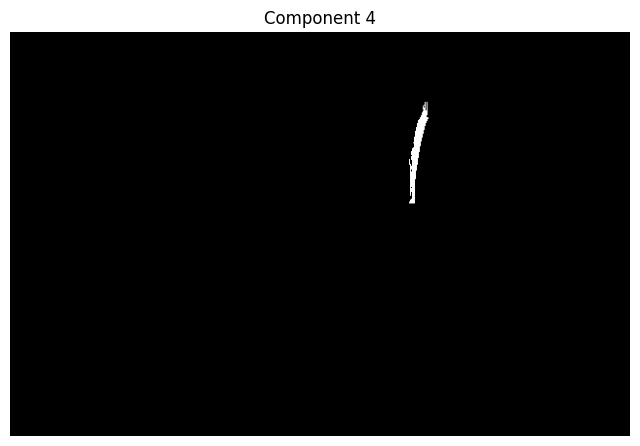

Component: 5
Area: 65882
Perimeter: 1996
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.18972991787345803
	- Moment 1: 0.0015143669486040912
	- Moment 2: 0.0002684992653960184
	- Moment 3: 0.00016683700186382997
	- Moment 4: 2.899649834296357e-08
	- Moment 5: 5.6359588845183785e-06
	- Moment 6: 2.015118791841523e-08
Mean per Color: [135.10010321 139.75431833  98.66871073]
	- Red: 135.10010321483864
	- Green: 139.75431832670532
	- Blue: 98.66871072523602
Variance per Color: [236.38497343 415.90211889 475.59456726]
	- Red: 236.3849734266648
	- Green: 415.90211888635986
	- Blue: 475.5945672609907


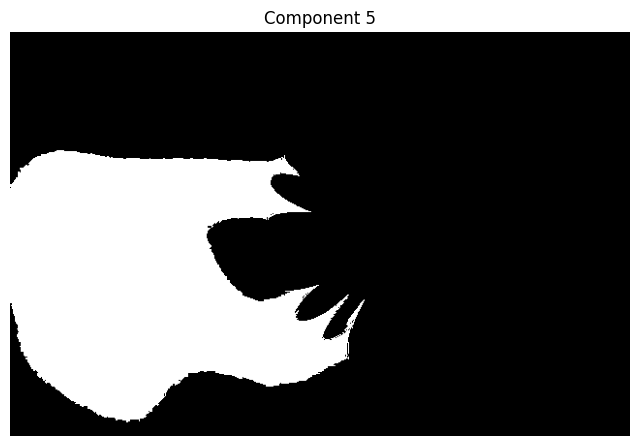

Component: 6
Area: 1279
Perimeter: 1134
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.6628143857595733
	- Moment 1: 0.17166304096502996
	- Moment 2: 0.11735199996631106
	- Moment 3: 0.032671127575693536
	- Moment 4: 0.001255472450942568
	- Moment 5: 0.005332277451160722
	- Moment 6: -0.0015862641839709556
Mean per Color: [ 70.80531665 151.05551212 172.09460516]
	- Red: 70.80531665363566
	- Green: 151.05551211884284
	- Blue: 172.09460516028147
Variance per Color: [3203.0418482   495.70528432  613.19120624]
	- Red: 3203.0418481991796
	- Green: 495.7052843155288
	- Blue: 613.1912062358148


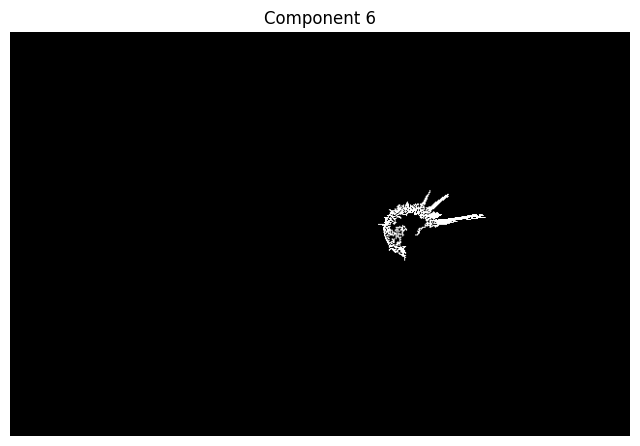

Component: 7
Area: 34610
Perimeter: 1375
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.7944862746878792
	- Moment 1: 0.5718207019338971
	- Moment 2: 0.07769626774593023
	- Moment 3: 0.06576029731270064
	- Moment 4: 0.004691269048013127
	- Moment 5: 0.0483787629432993
	- Moment 6: -0.0002947291481275524
Mean per Color: [89.83068477 88.04819416 47.47018203]
	- Red: 89.83068477318695
	- Green: 88.04819416353655
	- Blue: 47.47018202831551
Variance per Color: [209.9112919  262.81189287 103.47661739]
	- Red: 209.91129190323153
	- Green: 262.8118928672489
	- Blue: 103.47661738957169


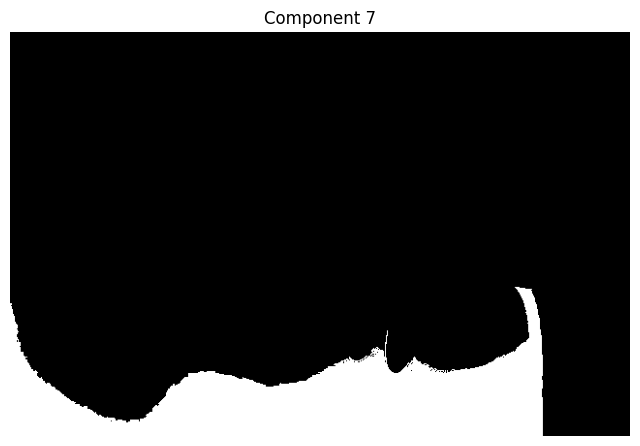

Component: 8
Area: 11199
Perimeter: 242
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.18193709638017425
	- Moment 1: 0.005185229364854907
	- Moment 2: 3.107685564937383e-05
	- Moment 3: 1.5739249750467265e-06
	- Moment 4: -8.9630371245741e-12
	- Moment 5: -1.0261062794611068e-07
	- Moment 6: -6.3900159238550935e-12
Mean per Color: [67.03518171 58.41789445 33.6308599 ]
	- Red: 67.03518171265291
	- Green: 58.417894454862044
	- Blue: 33.630859898205195
Variance per Color: [148.3105758  730.50292472 299.88516607]
	- Red: 148.31057580188534
	- Green: 730.5029247210852
	- Blue: 299.88516607009717


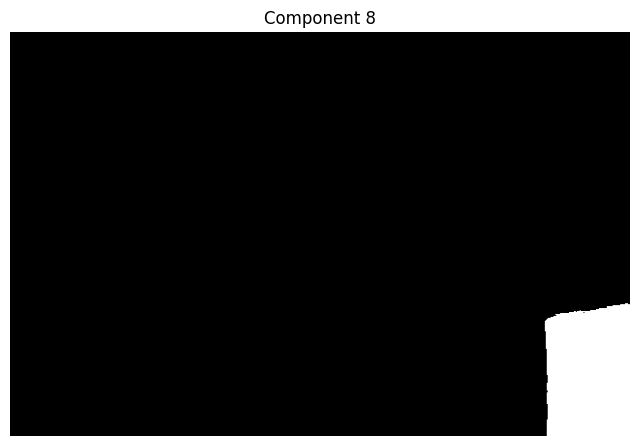

Component: 9
Area: 2257
Perimeter: 468
Hu Moments: <class 'numpy.ndarray'>
	- Moment 0: 0.3507833612285554
	- Moment 1: 0.043269714080223814
	- Moment 2: 0.0044832684950917995
	- Moment 3: 0.0006110413420287986
	- Moment 4: -3.457815155018595e-07
	- Moment 5: 4.77036583507538e-05
	- Moment 6: 9.504064328488616e-07
Mean per Color: [108.06025698 124.57953035  84.5201595 ]
	- Red: 108.06025697828977
	- Green: 124.57953035002215
	- Blue: 84.52015950376607
Variance per Color: [ 83.11023706 113.89188051 177.62132598]
	- Red: 83.11023706289467
	- Green: 113.89188050605598
	- Blue: 177.62132598253461


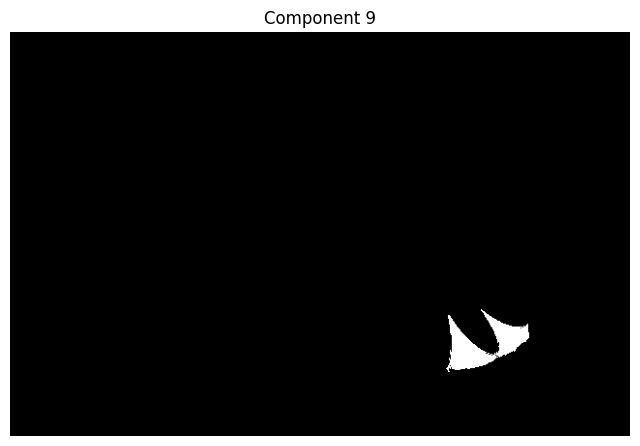

In [62]:
segmentationPipe("testImg3.jpg")